In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import json
import shutil
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()
src_path = f"{root}/src"
notebook_path = f"{root}/notebooks"

if src_path not in sys.path:
    sys.path.append(src_path)
    
if notebook_path not in sys.path:
    sys.path.append(notebook_path)


### Examples of anomalies and valid reprojections (with good calibration)

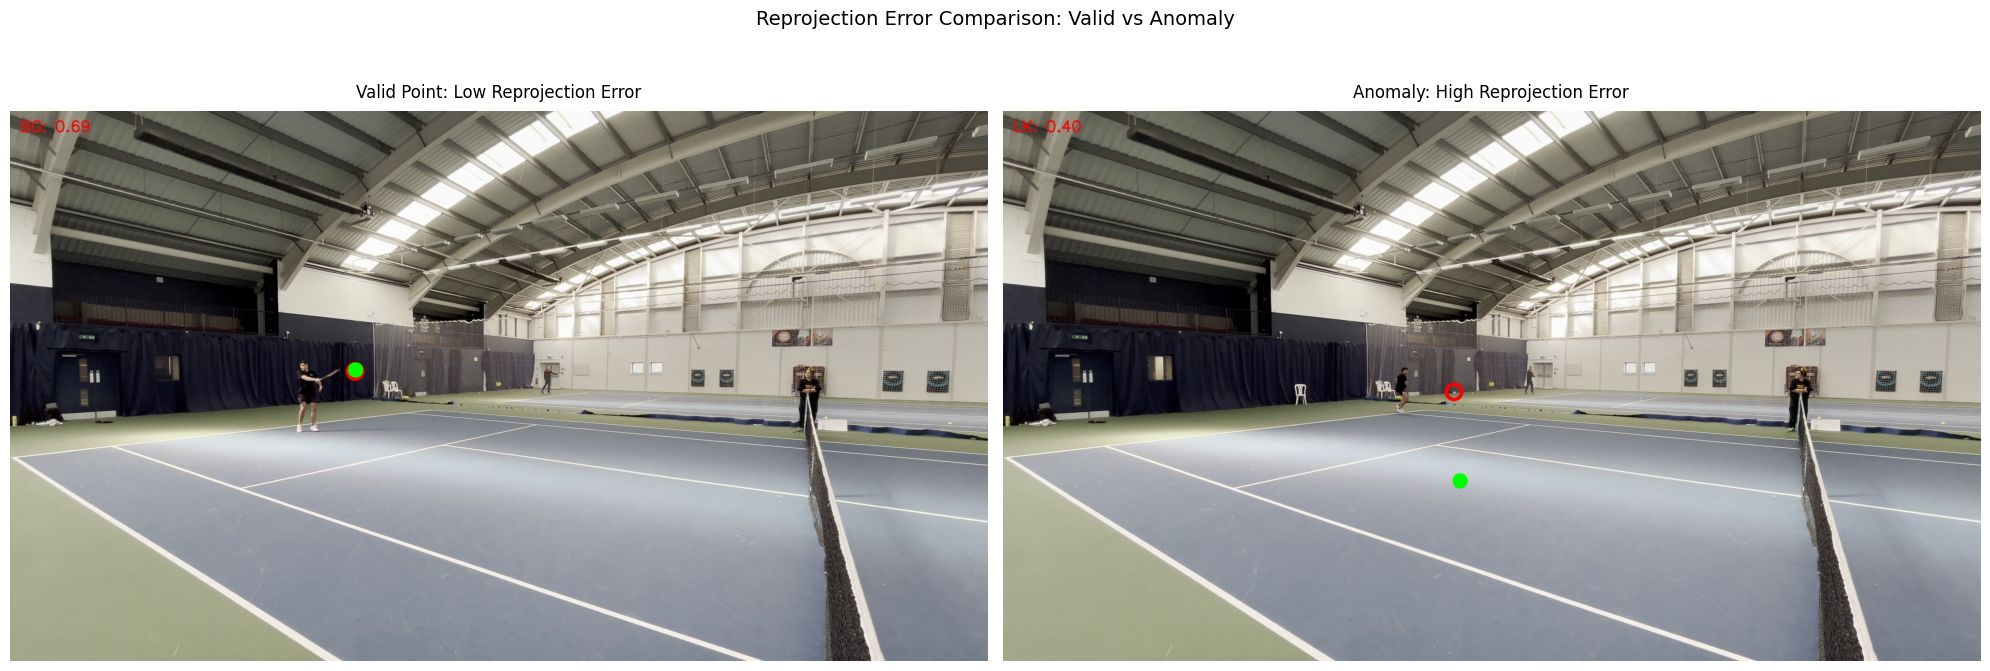

In [11]:
valid_example = f"{root}/reprojected_frames_B/valid/frame_1103" # very accurate
valid_example_2 = f"{root}/reprojected_frames_B/valid/frame_1155" # very accurate
valid_example_3 = f"{root}/reprojected_frames_B/valid/frame_1171" # less accurate but valid

anomalie_example = f"{root}/reprojected_frames_B/anomalies/frame_1354"
anomalie_example_2 = f"{root}/reprojected_frames_B/anomalies/frame_1385"

import os
import matplotlib.image as mpimg

# Get first image from each example folder
valid_img_path = os.path.join(valid_example_2, os.listdir(valid_example_2)[1])  # very accurate example
anomaly_img_path = os.path.join(anomalie_example, os.listdir(anomalie_example)[1])

# Read the images
valid_img = mpimg.imread(valid_img_path)
anomaly_img = mpimg.imread(anomaly_img_path)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the images
ax1.imshow(valid_img)
ax1.set_title('Valid Point: Low Reprojection Error', pad=10, fontsize=12)
ax1.axis('off')

ax2.imshow(anomaly_img)
ax2.set_title('Anomaly: High Reprojection Error', pad=10, fontsize=12)
ax2.axis('off')

# Add a main title
plt.suptitle('Reprojection Error Comparison: Valid vs Anomaly', y=0.95, fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()


### Example of valid calibration triangulation (good vs bad calibration)

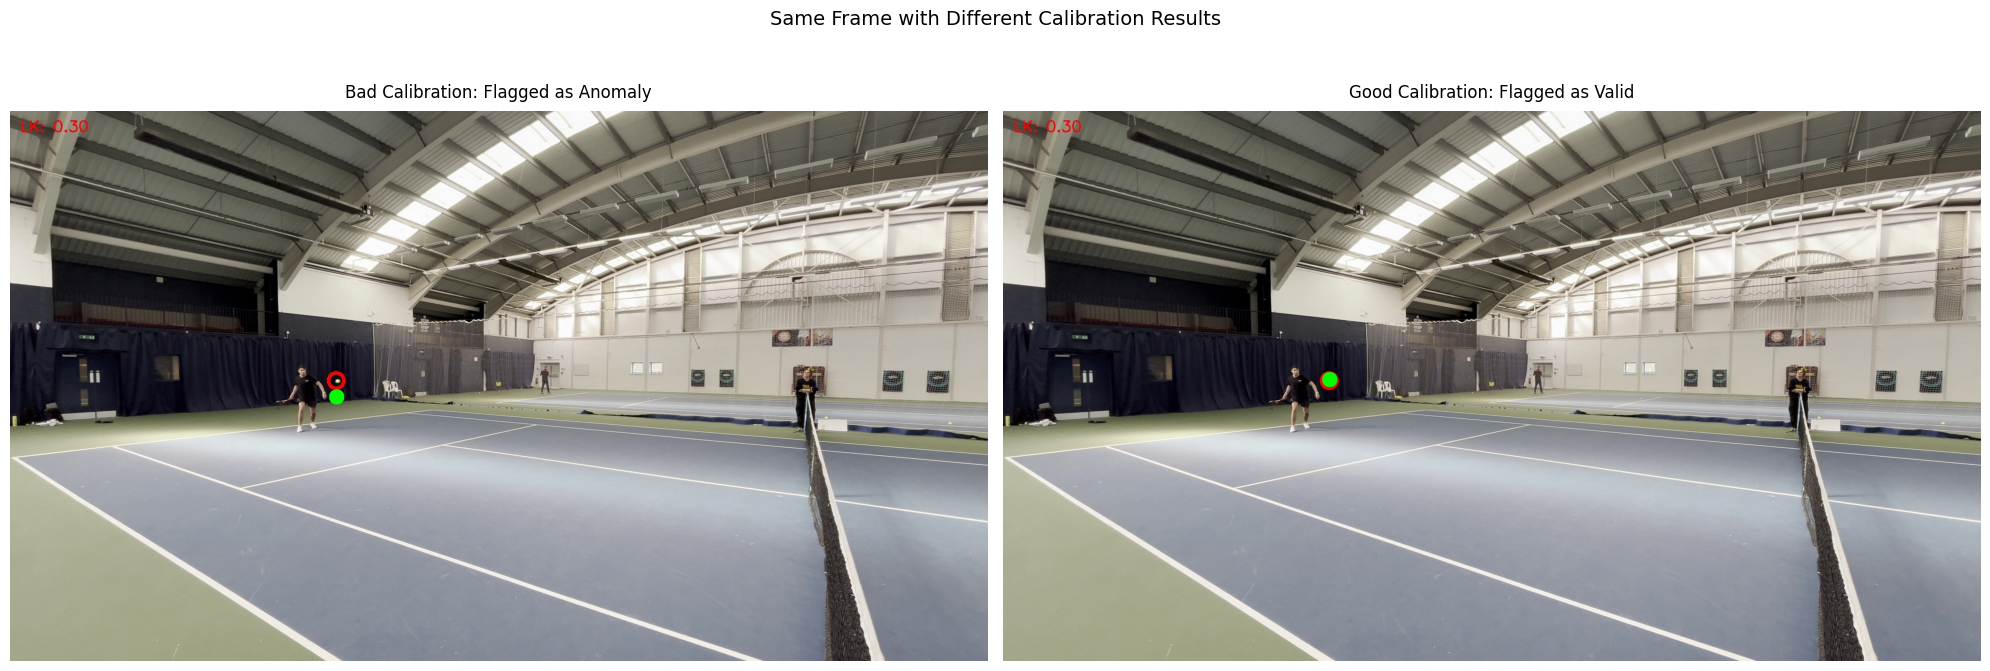

In [12]:
# search for a frame that was flagged as anomaly but was just bad triangulation
# then show the same frame flagged as valid due to good calibration
import os
import matplotlib.image as mpimg

# Get first image from each folder
false_anomaly_folder = f"{root}/reprojected_frames_B_old/anomalies/frame_1126"
valid_folder = f"{root}/reprojected_frames_B/valid/frame_1126"

# Get the first image file from each folder
false_anomaly_img_path = os.path.join(false_anomaly_folder, os.listdir(false_anomaly_folder)[1])
valid_img_path = os.path.join(valid_folder, os.listdir(valid_folder)[1])

# Read the images
false_anomaly_img = mpimg.imread(false_anomaly_img_path)
valid_equivalent_img = mpimg.imread(valid_img_path)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the images
ax1.imshow(false_anomaly_img)
ax1.set_title('Bad Calibration: Flagged as Anomaly', pad=10, fontsize=12)
ax1.axis('off')

ax2.imshow(valid_equivalent_img)
ax2.set_title('Good Calibration: Flagged as Valid', pad=10, fontsize=12)
ax2.axis('off')

# Add a main title
plt.suptitle('Same Frame with Different Calibration Results', y=0.95, fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()



### Good calibration vs bad calibration

In [2]:
good_detections = pd.read_csv(f"{root}/data/stereo_B_detections_triangulated.csv")
bad_detections = pd.read_csv(f"{root}/data/stereo_B_bad.csv")

Good calibration


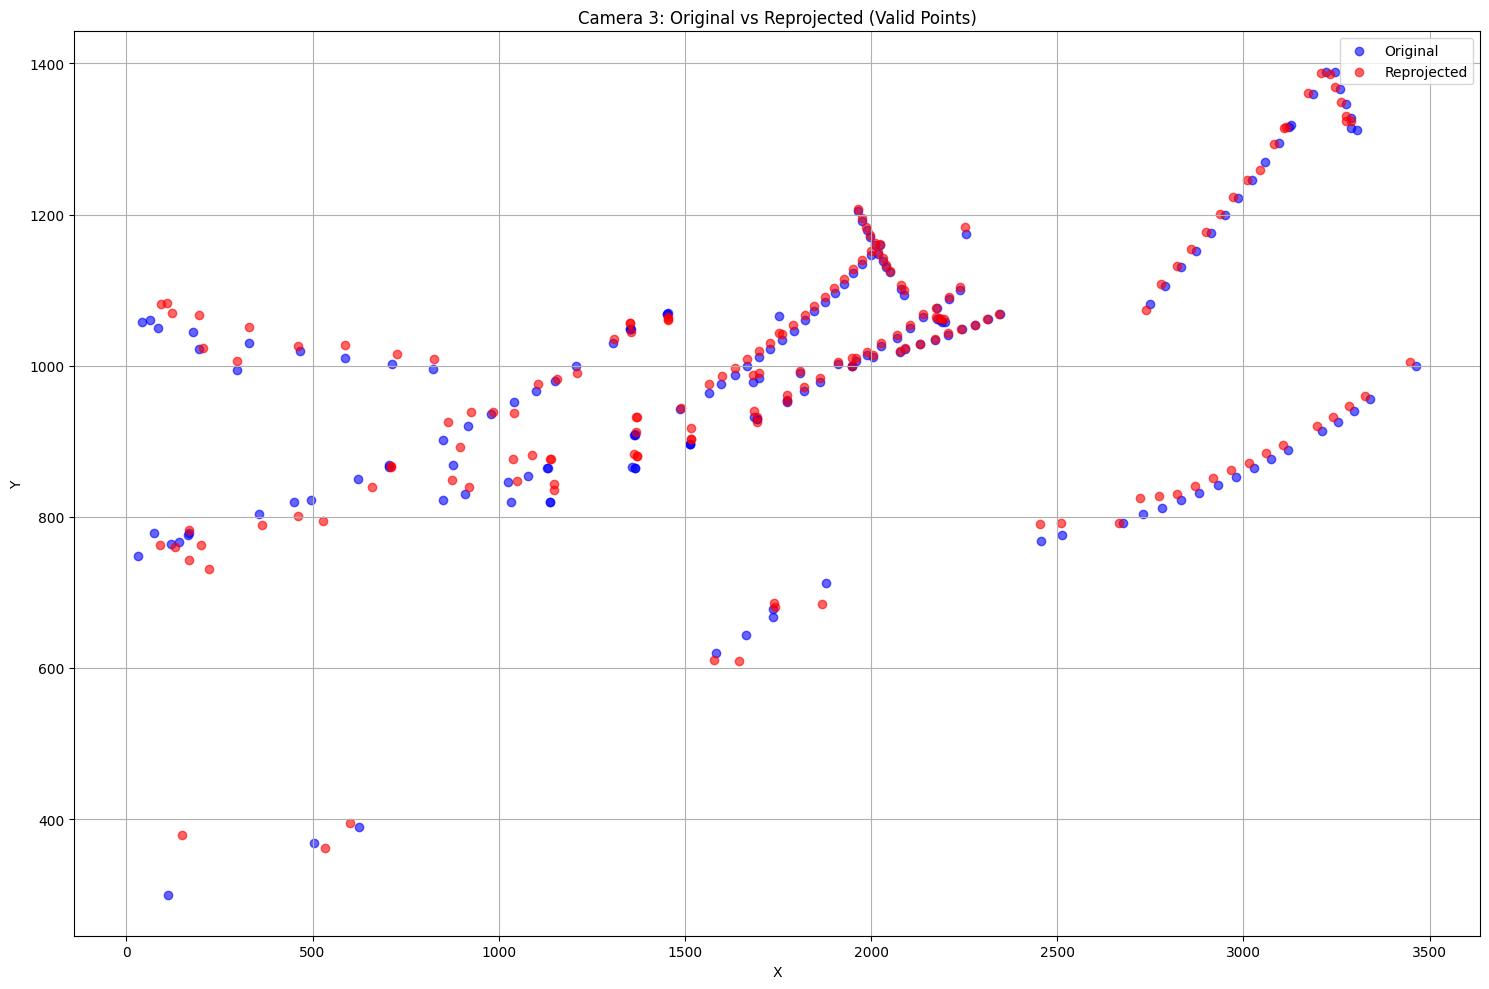

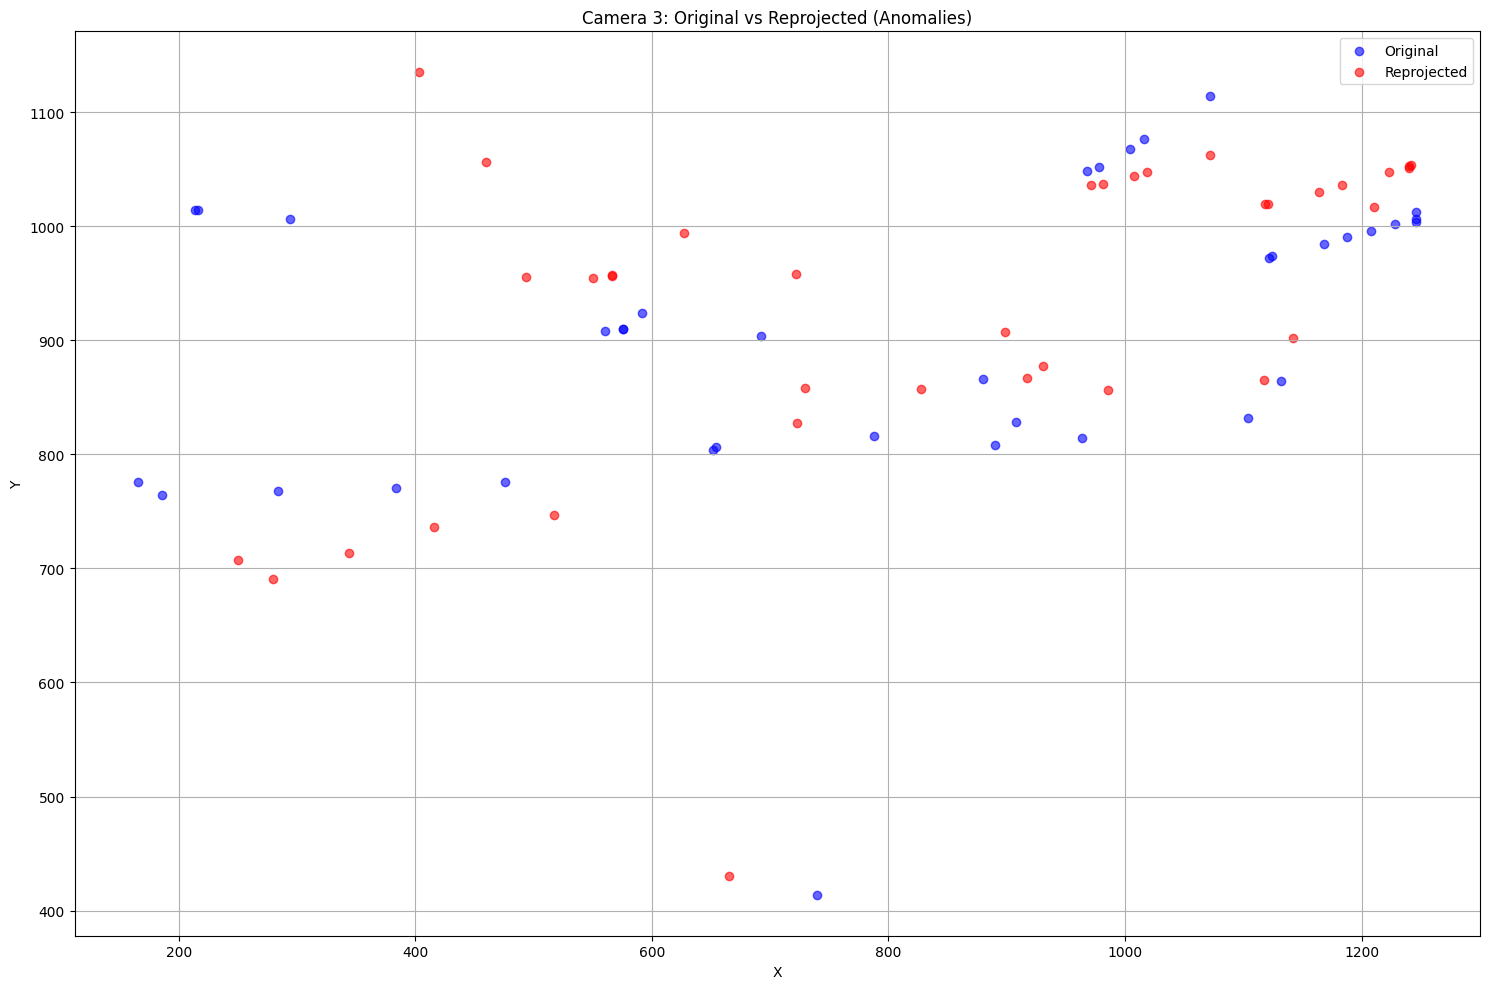

Bad calibration


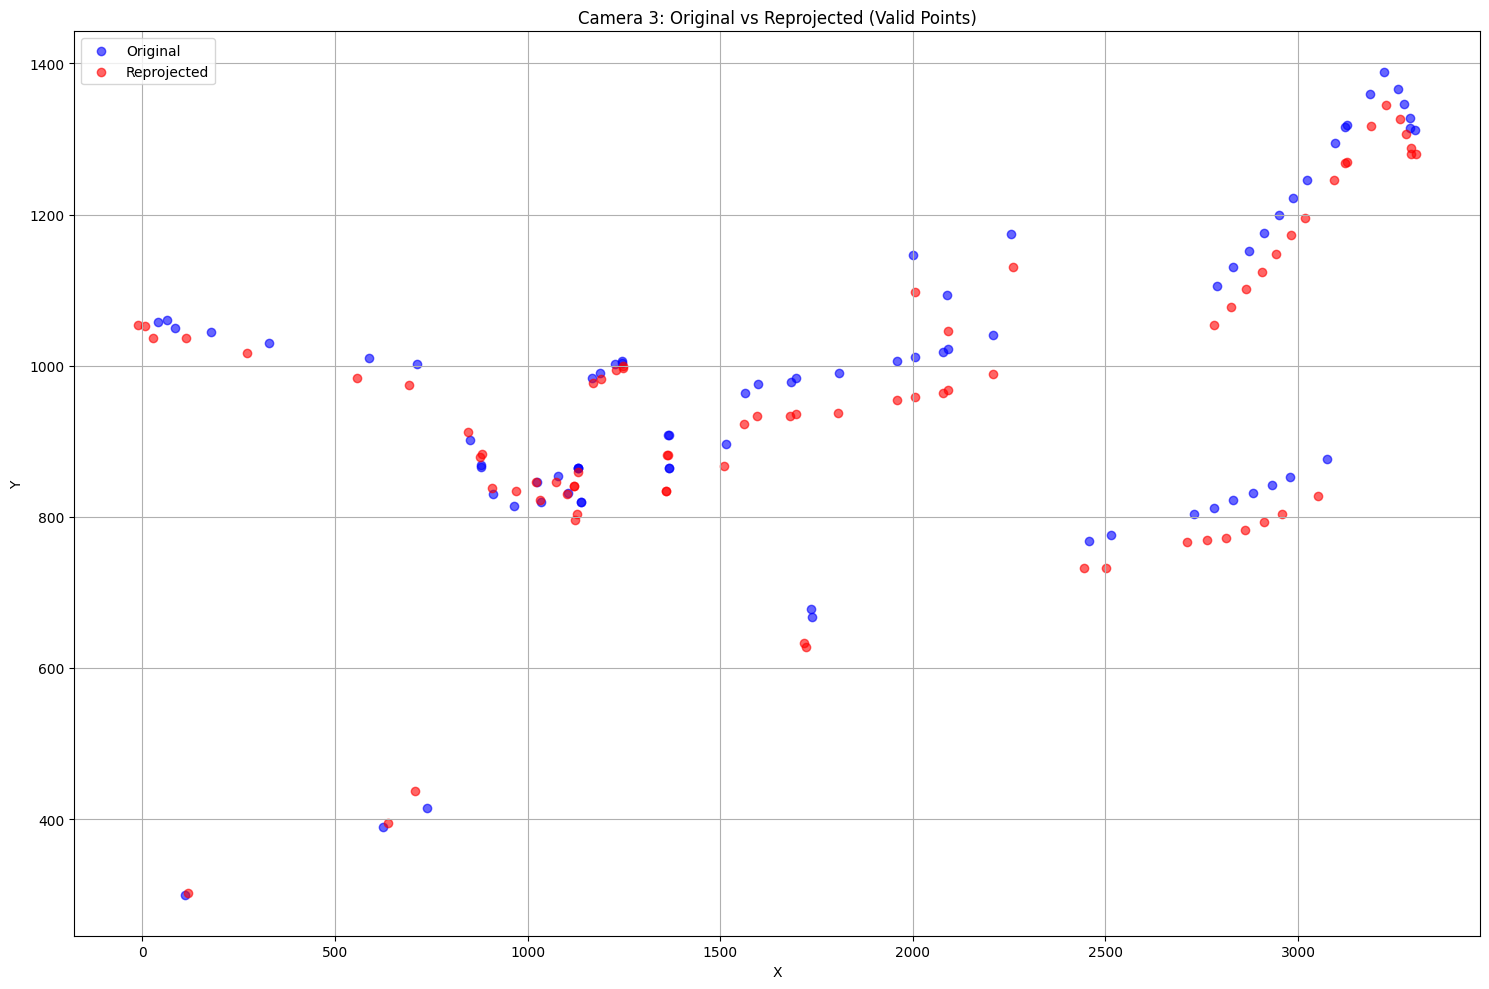

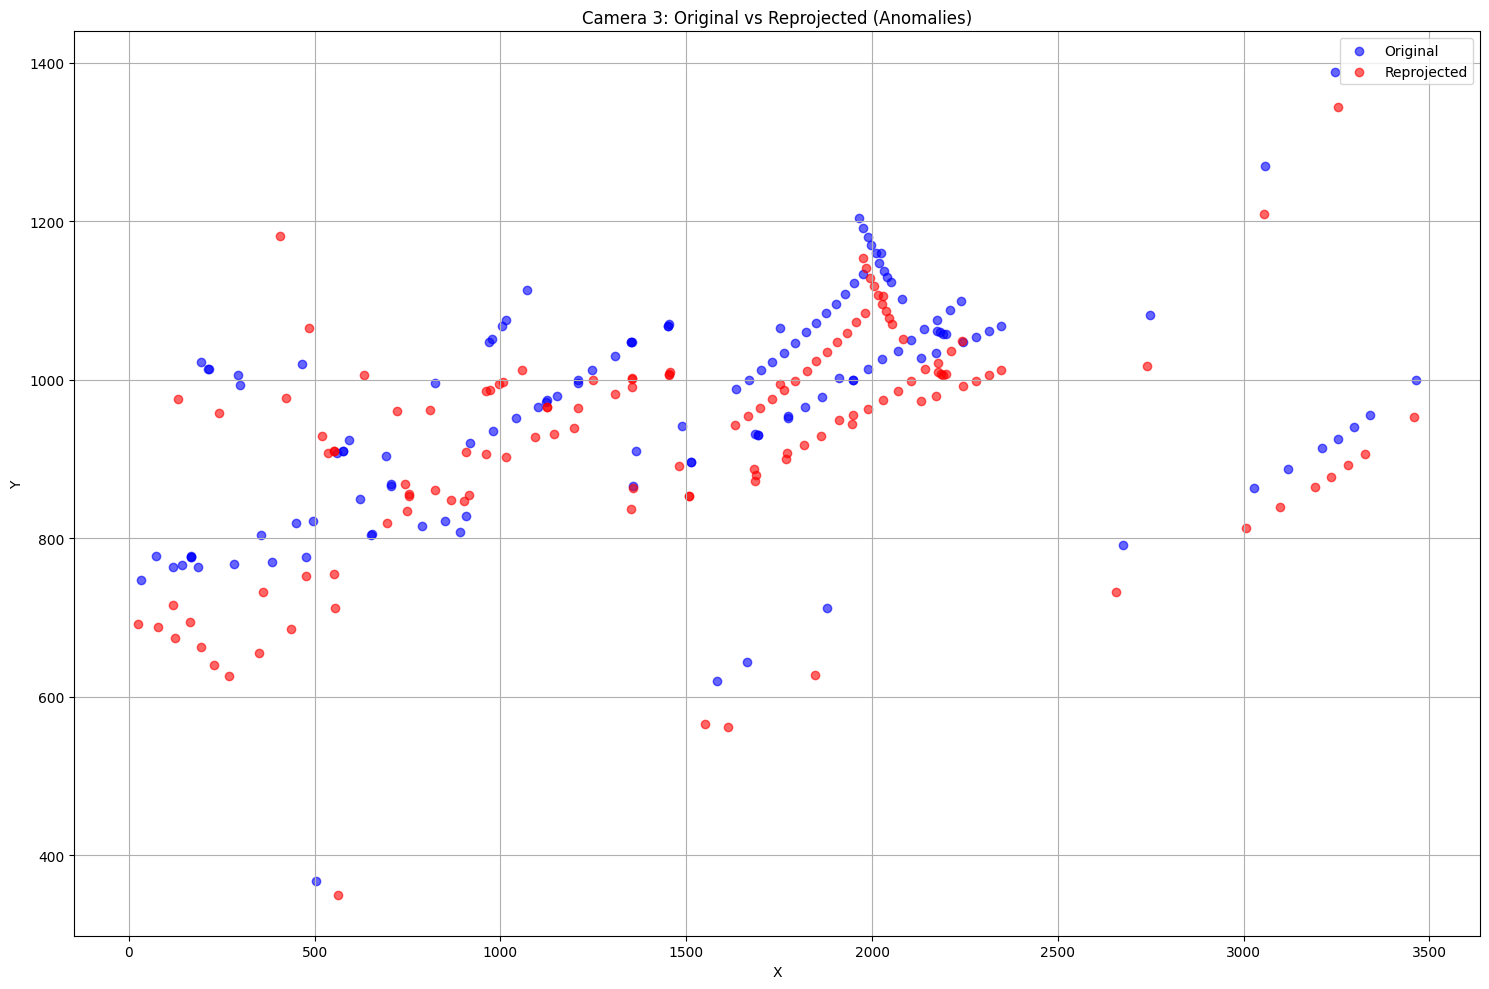

In [4]:
from plots import plot_anomaly_vs_original, plot_valid_vs_original

print("Good calibration")
plot_valid_vs_original(good_detections, stereo='B', camera_names=['Camera 3'])
plot_anomaly_vs_original(good_detections, stereo='B', camera_names=['Camera 3'])

print("Bad calibration")
plot_valid_vs_original(bad_detections, stereo='B', camera_names=['Camera 3'])
plot_anomaly_vs_original(bad_detections, stereo='B', camera_names=['Camera 3'])


/var/folders/8z/9lk7_58n1dzgvd97cfqznmxc0000gn/T/ipykernel_77844/3809481517.py:19: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  barplot = sns.barplot(x='calibration', y='count', hue='point_type', data=df,


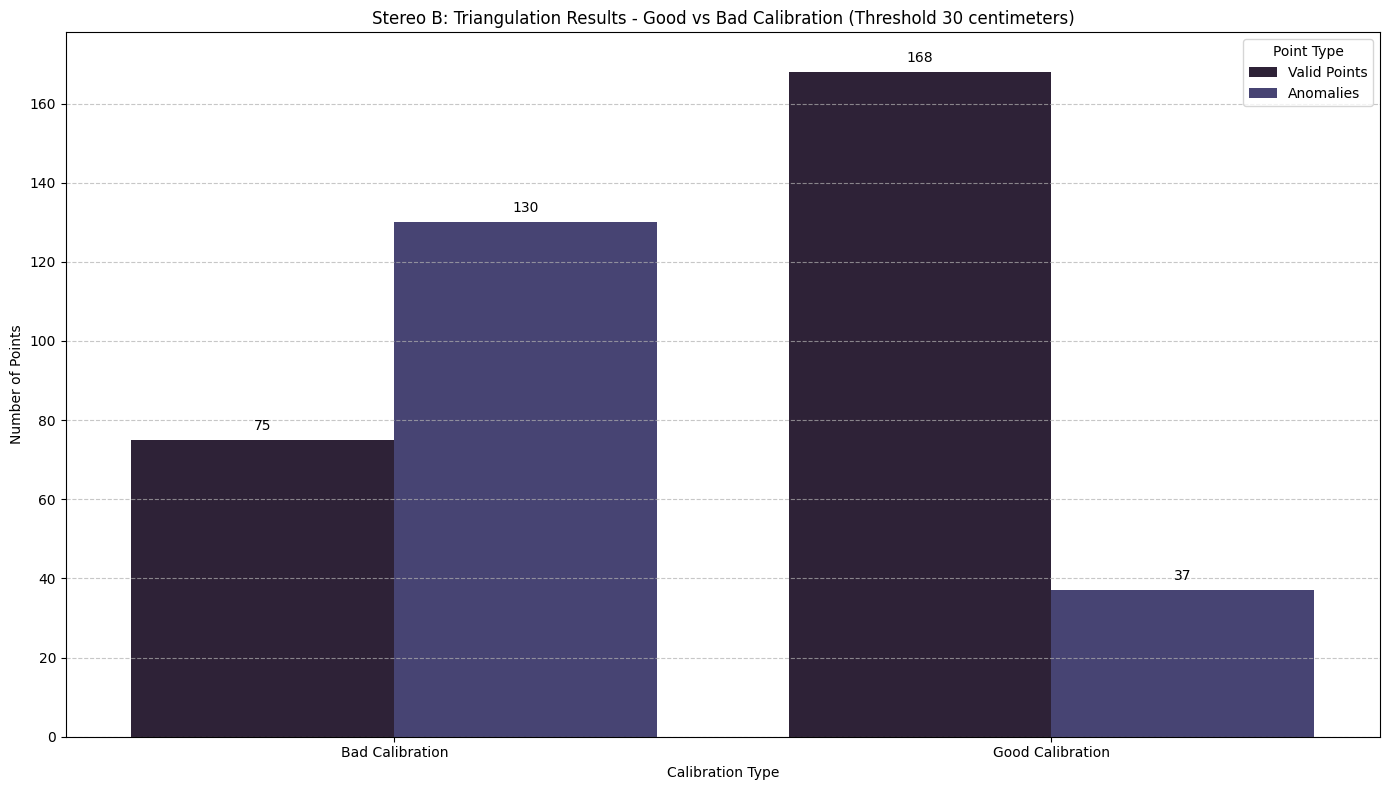

In [18]:
# plot stereo B good calibration vs bad calibration
# for each of those stereo B plot two bars, one bar for the valid points and another the anomalies
# Count valid points and anomalies for each calibration
good_valid = len(good_detections[good_detections['anomaly_detected'] == False])
good_anomalies = len(good_detections[good_detections['anomaly_detected'] == True])
bad_valid = len(bad_detections[bad_detections['anomaly_detected'] == False])
bad_anomalies = len(bad_detections[bad_detections['anomaly_detected'] == True])

df = pd.DataFrame({
    'calibration': ['Bad Calibration', 'Bad Calibration', 'Good Calibration', 'Good Calibration'],  # Reordered
    'point_type': ['Valid Points', 'Anomalies', 'Valid Points', 'Anomalies'],
    'count': [bad_valid, bad_anomalies, good_valid, good_anomalies]  # Reordered
})

# Create the plot
plt.figure(figsize=(14, 8))
point_order = ['Valid Points', 'Anomalies']

barplot = sns.barplot(x='calibration', y='count', hue='point_type', data=df,
                      palette=sns.color_palette("mako"),
                      errorbar=None,
                      hue_order=point_order)

plt.title('Stereo B: Triangulation Results - Good vs Bad Calibration (Threshold 30 centimeters)')
plt.xlabel('Calibration Type')
plt.ylabel('Number of Points')
plt.legend(title='Point Type', loc='upper right')
plt.ylim(0, df['count'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with exact values
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(f'{int(height)}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

/var/folders/8z/9lk7_58n1dzgvd97cfqznmxc0000gn/T/ipykernel_77844/725662899.py:35: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  barplot = sns.barplot(x='camera', y='error', hue='calibration', data=df,


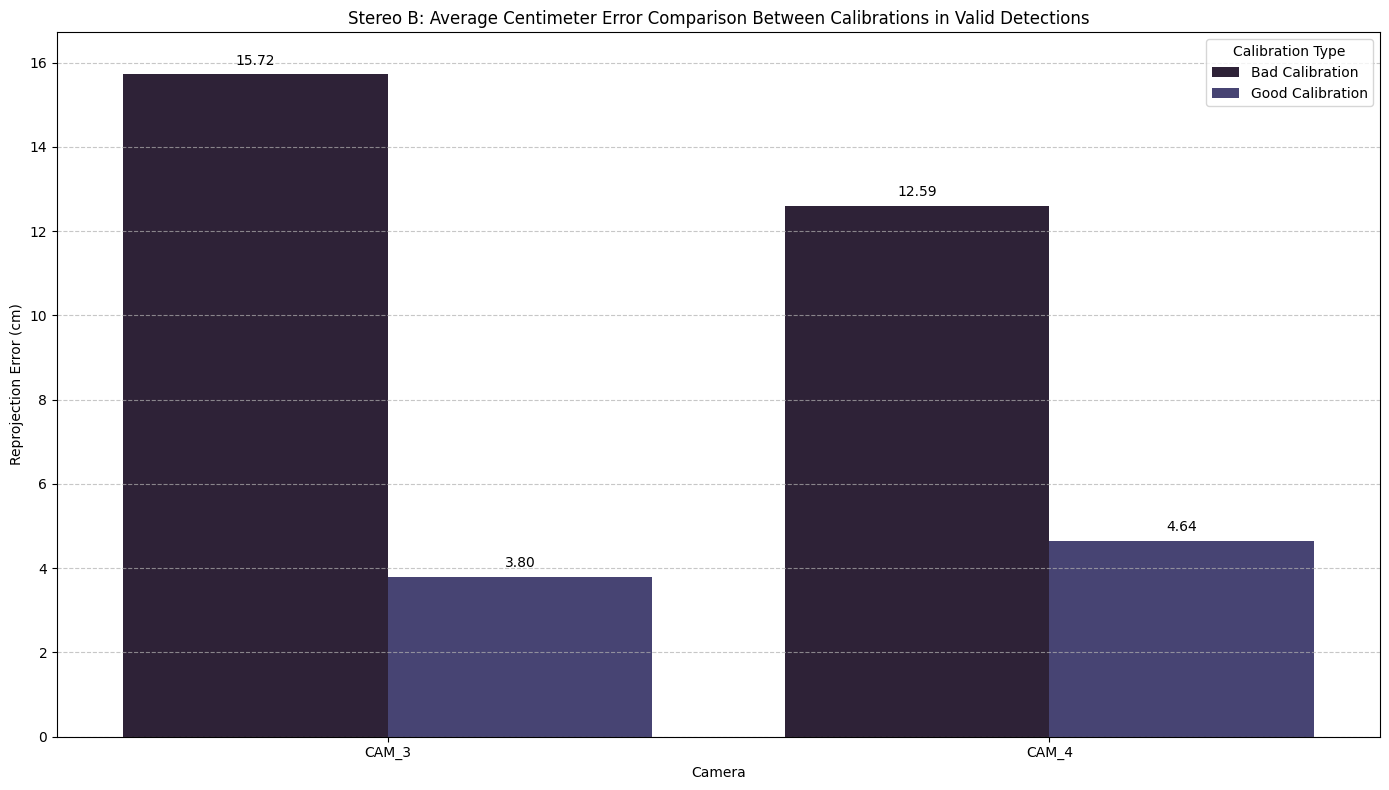

In [20]:
stereo_b_bad_results = f"{root}/output/triangulation_result_summary/1_triangulation_B.json"
stero_b_good_results = f"{root}/output/triangulation_result_summary/V2_triangulation_B.json"

with open(stereo_b_bad_results, 'r') as f:
    stero_b_bad_results = json.load(f)

with open(stero_b_good_results, 'r') as f:
    stero_b_good_results = json.load(f)

b_good_data = {
    "CAM_3_cm_error": stero_b_good_results["B1_average_cm_error"],
    "CAM_4_cm_error": stero_b_good_results["B2_average_cm_error"],
}

b_bad_data = {
    "CAM_3_cm_error": stero_b_bad_results["B1_average_cm_error"],
    "CAM_4_cm_error": stero_b_bad_results["B2_average_cm_error"],
}

df = pd.DataFrame({
    'camera': ['CAM_3', 'CAM_4', 'CAM_3', 'CAM_4'],
    'calibration': ['Bad Calibration', 'Bad Calibration', 'Good Calibration', 'Good Calibration'],  # Reordered
    'error': [
        b_bad_data['CAM_3_cm_error'],    # Bad calibration first
        b_bad_data['CAM_4_cm_error'],    # Bad calibration first
        b_good_data['CAM_3_cm_error'],
        b_good_data['CAM_4_cm_error']
    ]
})

# Create the plot
plt.figure(figsize=(14, 8))
camera_order = ['CAM_3', 'CAM_4']

barplot = sns.barplot(x='camera', y='error', hue='calibration', data=df,
                      palette=sns.color_palette("mako"),
                      errorbar=None,
                      order=camera_order)

plt.title('Stereo B: Average Centimeter Error Comparison Between Calibrations in Valid Detections')
plt.xlabel('Camera')
plt.ylabel('Reprojection Error (cm)')
plt.legend(title='Calibration Type', loc='upper right')
plt.ylim(0, df['error'].max() + 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with exact values
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(f'{height:.2f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

### Plot final triangulation results

In [29]:
stero_a_results = f"{root}/output/triangulation_result_summary/V2_triangulation_A.json"
stero_b_results = f"{root}/output/triangulation_result_summary/V2_triangulation_B.json"

with open(stero_a_results, 'r') as f:
    stero_a_results = json.load(f)

with open(stero_b_results, 'r') as f:
    stero_b_results = json.load(f)

a_data = {
  "total_raw_points": stero_a_results["total_raw_set"],
  "total_points": stero_a_results["total_filtered_set"],
  "total_valid": stero_a_results["valid_detections"],
  "total_anomalies": stero_a_results["total_filtered_set"] - stero_a_results["valid_detections"],
  "percentage_valid": stero_a_results["percentage_valid_detections"],
  "CAM_1_cm_error": stero_a_results["A1_average_cm_error"],
  "CAM_2_cm_error": stero_a_results["A2_average_cm_error"],
}

b_data = {
  "total_raw_points": stero_b_results["total_raw_set"],
  "total_points": stero_b_results["total_filtered_set"],
  "total_valid": stero_b_results["valid_detections"],
  "total_anomalies": stero_b_results["total_filtered_set"] - stero_b_results["valid_detections"],
  "percentage_valid": stero_b_results["percentage_valid_detections"],
  "CAM_3_cm_error": stero_b_results["B1_average_cm_error"],
  "CAM_4_cm_error": stero_b_results["B2_average_cm_error"],
}




/var/folders/8z/9lk7_58n1dzgvd97cfqznmxc0000gn/T/ipykernel_37454/2785681955.py:16: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='stereo', y='count', hue='metric', data=df,


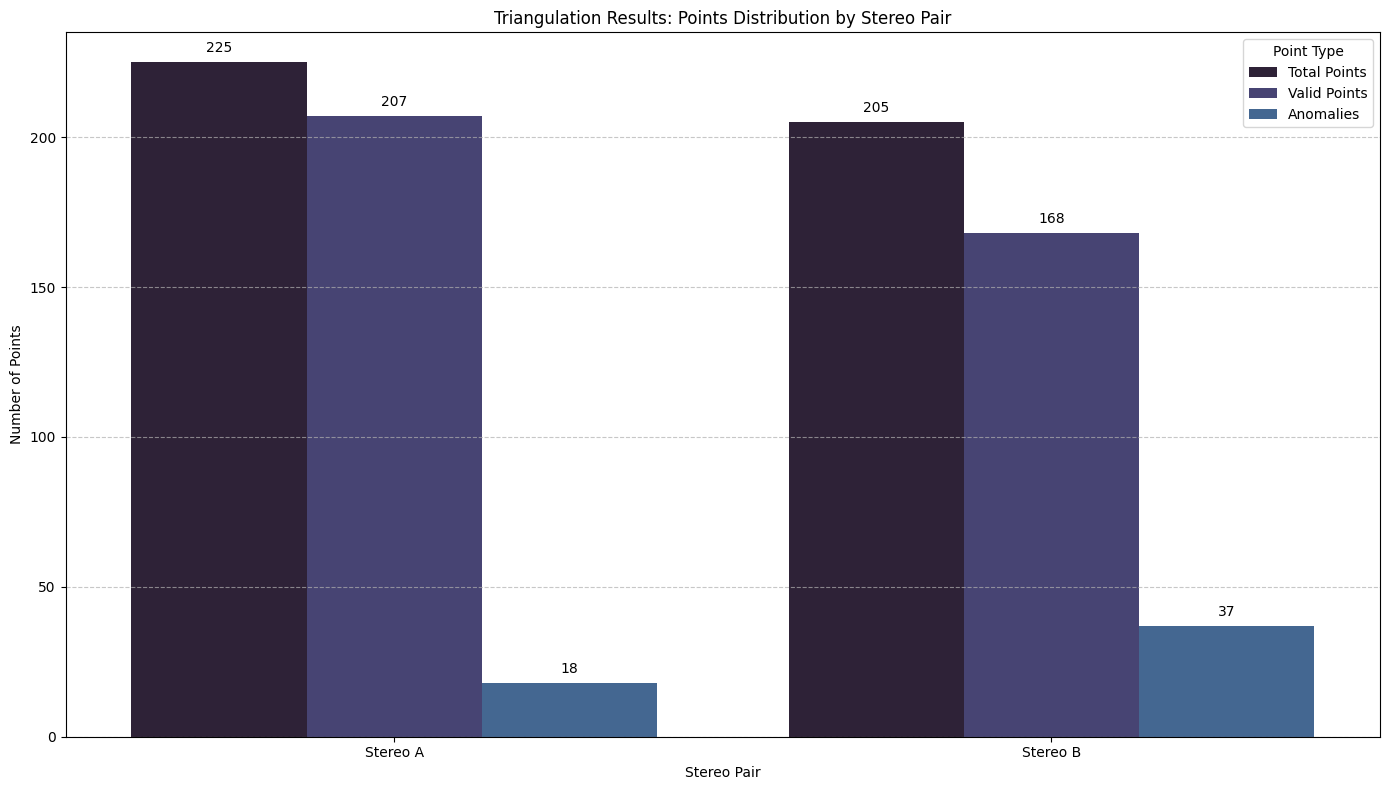

In [23]:
# plot total points, total valid, total anomalies for both stereos
# Prepare the data
df = pd.DataFrame({
    'stereo': ['Stereo A', 'Stereo A', 'Stereo A', 'Stereo B', 'Stereo B', 'Stereo B'],
    'metric': ['Total Points', 'Valid Points', 'Anomalies'] * 2,
    'count': [
        a_data['total_points'], a_data['total_valid'], a_data['total_anomalies'],
        b_data['total_points'], b_data['total_valid'], b_data['total_anomalies']
    ]
})

# Create the plot
plt.figure(figsize=(14, 8))
metric_order = ['Total Points', 'Valid Points', 'Anomalies']

barplot = sns.barplot(x='stereo', y='count', hue='metric', data=df, 
                     palette=sns.color_palette("mako"), 
                     errorbar=None,
                     hue_order=metric_order)

plt.title('Triangulation Results: Points Distribution by Stereo Pair')
plt.xlabel('Stereo Pair')
plt.ylabel('Number of Points')
plt.legend(title='Point Type', loc='upper right')
plt.ylim(0, df['count'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with exact values
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        xytext=(0, 5),
                        textcoords='offset points')

plt.tight_layout()
plt.show()



/var/folders/8z/9lk7_58n1dzgvd97cfqznmxc0000gn/T/ipykernel_37454/3761241903.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='camera', y='error', data=df,


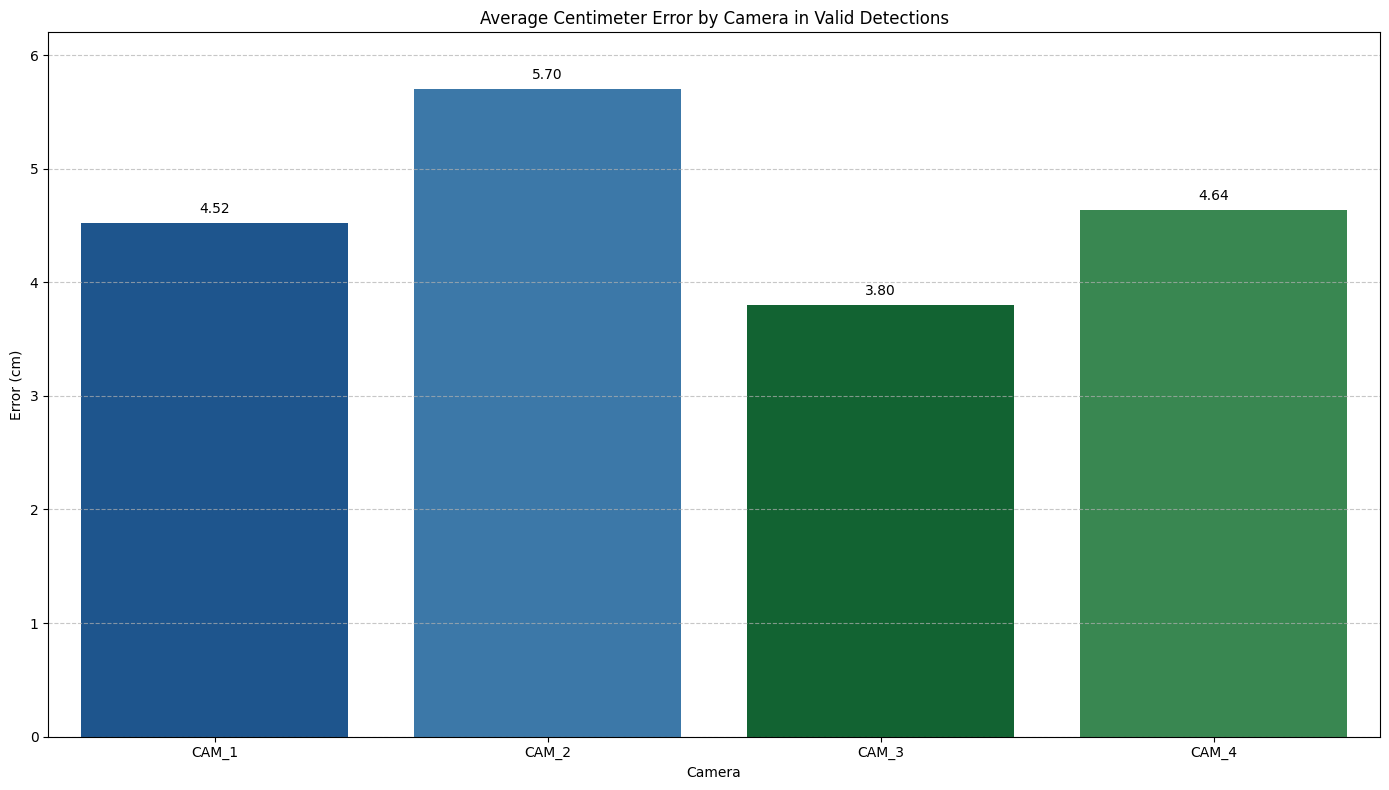

In [27]:
# Prepare the data
df = pd.DataFrame({
    'camera': ['CAM_1', 'CAM_2', 'CAM_3', 'CAM_4'],
    'stereo': ['Stereo A', 'Stereo A', 'Stereo B', 'Stereo B'],
    'error': [
        a_data['CAM_1_cm_error'],
        a_data['CAM_2_cm_error'],
        b_data['CAM_3_cm_error'],
        b_data['CAM_4_cm_error']
    ]
})

# Create the plot
plt.figure(figsize=(14, 8))
camera_order = ['CAM_1', 'CAM_2', 'CAM_3', 'CAM_4']

# Use different colors for each stereo
colors = {'Stereo A': sns.color_palette("Blues_r")[:2], 
          'Stereo B': sns.color_palette("Greens_r")[:2]}
palette = [colors['Stereo A'][0], colors['Stereo A'][1], 
          colors['Stereo B'][0], colors['Stereo B'][1]]

barplot = sns.barplot(x='camera', y='error', data=df, 
                     palette=palette,
                     errorbar=None,
                     order=camera_order)

plt.title('Average Centimeter Error by Camera in Valid Detections')
plt.xlabel('Camera')
plt.ylabel('Error (cm)')
plt.ylim(0, df['error'].max() + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with exact values
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(f'{height:.2f}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        xytext=(0, 5),
                        textcoords='offset points')

plt.tight_layout()
plt.show()

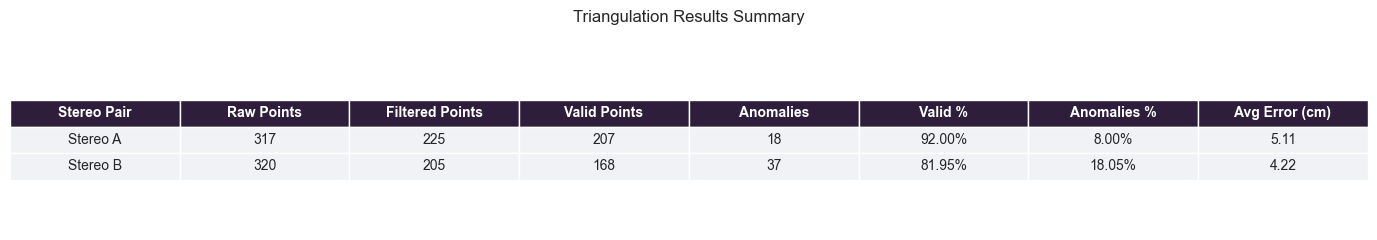

In [32]:
# Prepare table data
table_data = []

# Stereo A data
stereo_a_avg_error = (a_data['CAM_1_cm_error'] + a_data['CAM_2_cm_error']) / 2
percentage_anomalies_a = 100 - a_data['percentage_valid']  # Calculate anomalies percentage
table_data.append([
    'Stereo A',
    int(a_data['total_raw_points']),
    int(a_data['total_points']),
    int(a_data['total_valid']),
    int(a_data['total_anomalies']),
    f"{a_data['percentage_valid']:.2f}%",
    f"{percentage_anomalies_a:.2f}%",
    f"{stereo_a_avg_error:.2f}"
])

# Stereo B data
stereo_b_avg_error = (b_data['CAM_3_cm_error'] + b_data['CAM_4_cm_error']) / 2
percentage_anomalies_b = 100 - b_data['percentage_valid']  # Calculate anomalies percentage
table_data.append([
    'Stereo B',
    int(b_data['total_raw_points']),
    int(b_data['total_points']),
    int(b_data['total_valid']),
    int(b_data['total_anomalies']),
    f"{b_data['percentage_valid']:.2f}%",
    f"{percentage_anomalies_b:.2f}%",
    f"{stereo_b_avg_error:.2f}"
])

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 2.5))
ax.axis('tight')
ax.axis('off')

# Update column labels
table = ax.table(cellText=table_data,
                colLabels=['Stereo Pair', 'Raw Points', 'Filtered Points', 'Valid Points', 'Anomalies', 'Valid %', 'Anomalies %', 'Avg Error (cm)'],
                cellLoc='center',
                loc='center',
                colColours=[sns.color_palette("mako")[0]]*8)  # Updated number of columns

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.3, 1.7)

# Style the cells
for cell in table._cells:
    table._cells[cell].set_edgecolor('#FFFFFF')
    if cell[0] == 0:  # Header row
        table._cells[cell].set_text_props(color='white', weight='bold')
        table._cells[cell].set_facecolor(sns.color_palette("mako")[0])
    else:  # Data rows
        table._cells[cell].set_facecolor('#F0F2F6')

plt.title('Triangulation Results Summary', pad=20)
plt.tight_layout()
plt.show()